<a href="https://colab.research.google.com/github/tkoyama010/Colaboratory/blob/master/Cantilever.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 片持ちはりの検討

有限要素法ライブラリGetFEM++を使用して片持ちはりの検討を行います。まずは、GetFEM++をインストールします。

## ライブラリのインストール

In [0]:
!apt install python-getfem++=5.2+dfsg1-6

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libgetfem5++ libmumps-seq-5.1.2 libscotch-6.0 python-decorator
  python-olefile python-pil python-scipy
Suggested packages:
  python-pil-doc python-pil-dbg python-scipy-doc
The following NEW packages will be installed:
  libgetfem5++ libmumps-seq-5.1.2 libscotch-6.0 python-decorator
  python-getfem++ python-olefile python-pil python-scipy
0 upgraded, 8 newly installed, 0 to remove and 25 not upgraded.
Need to get 15.2 MB of archives.
After this operation, 66.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libscotch-6.0 amd64 6.0.4.dfsg1-8 [403 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libmumps-seq-5.1.2 amd64 5.1.2-4 [1,119 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 python-decorator all 4.1.2-1 [9,300 B]
Get:4 http://archive.ubuntu.com/ubunt

次に可視化ソフトMayavi2をインストールします。

In [0]:
!apt install mayavi2=4.5.0-1

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  avahi-daemon bind9-host cython geoclue-2.0 geoip-database
  gstreamer1.0-plugins-base iio-sensor-proxy javascript-common libaudio2
  libavahi-core7 libavahi-glib1 libbind9-160 libbrotli1 libcap2-bin
  libcdparanoia0 libdaemon0 libdns1100 libgeoclue-2-0 libgeoip1
  libgl1-mesa-glx libgstreamer-plugins-base1.0-0 libgstreamer1.0-0 libhyphen0
  libisc169 libisccc160 libisccfg160 libjs-sphinxdoc libjs-underscore
  liblwres160 libmbim-glib4 libmbim-proxy libmm-glib0 libmng2 libnl-genl-3-200
  libnotify4 libnss-mdns liborc-0.4-0 libpam-cap libqmi-glib5 libqmi-proxy
  libqt4-dbus libqt4-declarative libqt4-designer libqt4-help libqt4-network
  libqt4-script libqt4-scripttools libqt4-sql libqt4-sql-mysql libqt4-svg
  libqt4-test libqt4-xml libqt4-xmlpatterns libqt5opengl5 libqt5positioning5
  libqt5qml5 libqt5quick5 libqt5sensors5 libqt5webchannel

colab上にはディスプレイがないため、Mayavi2用に仮想ディスプレイを設定します。

In [0]:
!apt-get -y install xvfb=2:1.19.6-1ubuntu4.4
!pip install pyvirtualdisplay==0.2.5

from pyvirtualdisplay import Display
import os

display = Display(visible=0, size=(1280, 1024))
display.start()
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 25 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,266 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.4 [784 kB]
Fetched 784 kB in 1s (1,089 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 144238 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.4_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.4) ...
Setting up xvfb (2:1.19.6-1ubuntu4.4) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


No handlers could be found for logger "pyvirtualdisplay.abstractdisplay"


## モデルの作成

準備が整ったのでライブラリをインポートします。

In [0]:
import getfem as gf
import numpy as np


検討ケースは次の通りです。GetFEM++では下記の有限要素法と積分法をそれぞれFEM_PRODUCTとIM_PRODUCTを使用して2次元化します。2次要素についてはGauss積分点が3であるとします。IM_GAUSS1D(K)はK/2+1点の積分点を表します。要素は平面ひずみ要素を使用します。

ケース名 | メッシュ   | 有限要素法                     | 積分法        |
-------- | ---------- | ----------                     | ----------    |
case11   | 1 x 4      | FEM_PK(1, 2)                   | IM_GAUSS1D(4) |
case12   | 2 x 4      | FEM_PK(1, 2)                   | IM_GAUSS1D(4) |
case13   | 4 x 4      | FEM_PK(1, 2)                   | IM_GAUSS1D(4) |
case14   | 8 x 16     | FEM_PK(1, 2)                   | IM_GAUSS1D(4) |
case21   | 1 x 4      | FEM_PK(1, 1)                   | IM_GAUSS1D(2) |
case22   | 2 x 4      | FEM_PK(1, 1)                   | IM_GAUSS1D(2) |
case23   | 4 x 4      | FEM_PK(1, 1)                   | IM_GAUSS1D(2) |
case24   | 8 x 16     | FEM_PK(1, 1)                   | IM_GAUSS1D(2) |
case31   | 1 x 4      | FEM_PK(1, 1)                   | IM_GAUSS1D(0) |
case32   | 2 x 4      | FEM_PK(1, 1)                   | IM_GAUSS1D(0) |
case33   | 4 x 4      | FEM_PK(1, 1)                   | IM_GAUSS1D(0) |
case34   | 8 x 16     | FEM_PK(1, 1)                   | IM_GAUSS1D(0) |
case41   | 1 x 4      | FEM_PK_WITH_CUBIC_BUBBLE(1, 1) | IM_GAUSS1D(2) |
case42   | 2 x 4      | FEM_PK_WITH_CUBIC_BUBBLE(1, 1) | IM_GAUSS1D(2) |
case43   | 4 x 4      | FEM_PK_WITH_CUBIC_BUBBLE(1, 1) | IM_GAUSS1D(2) |
case44   | 8 x 16     | FEM_PK_WITH_CUBIC_BUBBLE(1, 1) | IM_GAUSS1D(2) |

これらのメッシュ、有限要素法と積分法を設定します。

In [0]:
cases = [
    "case11",
    "case12",
    "case13",
    "case14",
    "case21",
    "case22",
    "case23",
    "case24",
    "case31",
    "case32",
    "case33",
    "case34",
    "case41",
    "case42",
    "case43",
    "case44",
]


### メッシュ

モデル全体のサイズは長さL=10mm、高さh=1mm、奥行きb=1mmとします。一般的にスレンダー比が1:10であれば、はり要素とみなせるといわれます。

In [0]:
L = 10.0
b = 1.0
h = 1.0

x04 = np.arange(4 + 1) * L / 4
x16 = np.arange(16 + 1) * L / 16

y01 = np.arange(1 + 1) * h / 1
y02 = np.arange(2 + 1) * h / 2
y04 = np.arange(4 + 1) * h / 4
y08 = np.arange(8 + 1) * h / 8

m1 = gf.Mesh("cartesian", x04, y01)
m2 = gf.Mesh("cartesian", x04, y02)
m3 = gf.Mesh("cartesian", x04, y04)
m4 = gf.Mesh("cartesian", x16, y08)

meshs = [m1, m2, m3, m4, m1, m2, m3, m4, m1, m2, m3, m4, m1, m2, m3, m4]

m1.export_to_vtk("mesh1.vtk")
m2.export_to_vtk("mesh2.vtk")
m3.export_to_vtk("mesh3.vtk")
m4.export_to_vtk("mesh4.vtk")


各メッシュの画像を出力します。

In [0]:
from mayavi import mlab

vtks = ["mesh1.vtk", "mesh2.vtk", "mesh3.vtk", "mesh4.vtk"]
pngs = ["mesh1.png", "mesh2.png", "mesh3.png", "mesh4.png"]

for vtk, png in zip(vtks, pngs):
    mlab.init_notebook()
    vtk_file_reader = mlab.pipeline.open(vtk)
    extract_edges = mlab.pipeline.extract_edges(vtk_file_reader)
    surface = mlab.pipeline.surface(extract_edges)
    mlab.show()
    mlab.savefig(png)
    mlab.clf()


/usr/lib/python2.7/dist-packages/traits/etsconfig/etsconfig.py:429: UserWarning: Environment variable "HOME" not set, setting home directory to /tmp
  (environment_variable, parent_directory))


Notebook initialized with x3d backend.
Notebook initialized with x3d backend.
Notebook initialized with x3d backend.
Notebook initialized with x3d backend.


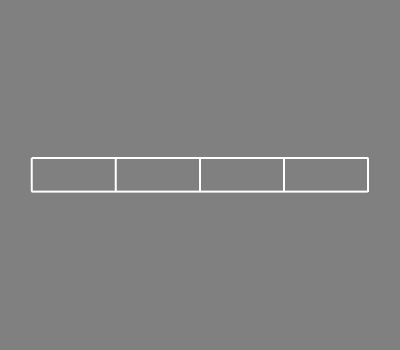

In [0]:
from IPython.display import Image, display_png

display_png(Image("mesh1.png"))


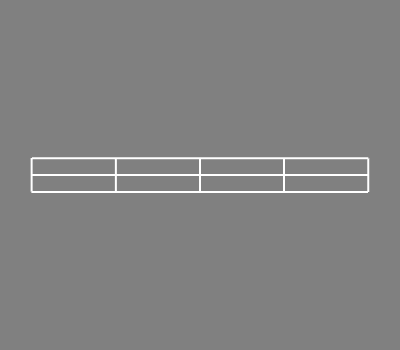

In [0]:
from IPython.display import Image, display_png

display_png(Image("mesh2.png"))


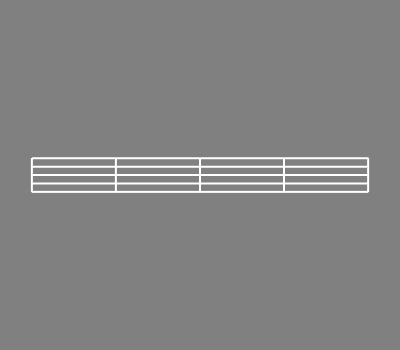

In [0]:
from IPython.display import Image, display_png

display_png(Image("mesh3.png"))


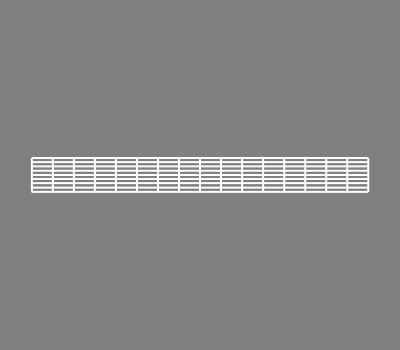

In [0]:
from IPython.display import Image, display_png

display_png(Image("mesh4.png"))


### 領域

メッシュの左側面にDirichlet条件を設定する領域を設定します。右側面にはNeumann条件を設定するための領域を設定します。

In [0]:
TOP_BOUND = 1
RIGHT_BOUND = 2
LEFT_BOUND = 3
BOTTOM_BOUND = 4

for mesh in meshs:
    fb1 = mesh.outer_faces_with_direction([0.0, 1.0], 0.01)
    fb2 = mesh.outer_faces_with_direction([1.0, 0.0], 0.01)
    fb3 = mesh.outer_faces_with_direction([-1.0, 0.0], 0.01)
    fb4 = mesh.outer_faces_with_direction([0.0, -1.0], 0.01)
    mesh.set_region(TOP_BOUND, fb1)
    mesh.set_region(RIGHT_BOUND, fb2)
    mesh.set_region(LEFT_BOUND, fb3)
    mesh.set_region(BOTTOM_BOUND, fb4)


### 有限要素法
MeshFemオブジェクトを作成しメッシュと有限要素法を関連付けます。

In [0]:
fems = []
# 2次要素
fems.append(gf.Fem("FEM_PRODUCT(FEM_PK(1, 2), FEM_PK(1, 2))"))
# 2次要素
fems.append(gf.Fem("FEM_PRODUCT(FEM_PK(1, 2), FEM_PK(1, 2))"))
# 2次要素
fems.append(gf.Fem("FEM_PRODUCT(FEM_PK(1, 2), FEM_PK(1, 2))"))
# 2次要素
fems.append(gf.Fem("FEM_PRODUCT(FEM_PK(1, 2), FEM_PK(1, 2))"))
# 1次要素
fems.append(gf.Fem("FEM_PRODUCT(FEM_PK(1, 1), FEM_PK(1, 1))"))
# 1次要素
fems.append(gf.Fem("FEM_PRODUCT(FEM_PK(1, 1), FEM_PK(1, 1))"))
# 1次要素
fems.append(gf.Fem("FEM_PRODUCT(FEM_PK(1, 1), FEM_PK(1, 1))"))
# 1次要素
fems.append(gf.Fem("FEM_PRODUCT(FEM_PK(1, 1), FEM_PK(1, 1))"))
# 1次要素
fems.append(gf.Fem("FEM_PRODUCT(FEM_PK(1, 1), FEM_PK(1, 1))"))
# 1次要素
fems.append(gf.Fem("FEM_PRODUCT(FEM_PK(1, 1), FEM_PK(1, 1))"))
# 1次要素
fems.append(gf.Fem("FEM_PRODUCT(FEM_PK(1, 1), FEM_PK(1, 1))"))
# 1次要素
fems.append(gf.Fem("FEM_PRODUCT(FEM_PK(1, 1), FEM_PK(1, 1))"))
# 非適合要素
fems.append(
    gf.Fem(
        "FEM_PRODUCT(FEM_PK_WITH_CUBIC_BUBBLE(1, 1), FEM_PK_WITH_CUBIC_BUBBLE(1, 1))"
    )
)
# 非適合要素
fems.append(
    gf.Fem(
        "FEM_PRODUCT(FEM_PK_WITH_CUBIC_BUBBLE(1, 1), FEM_PK_WITH_CUBIC_BUBBLE(1, 1))"
    )
)
# 非適合要素
fems.append(
    gf.Fem(
        "FEM_PRODUCT(FEM_PK_WITH_CUBIC_BUBBLE(1, 1), FEM_PK_WITH_CUBIC_BUBBLE(1, 1))"
    )
)
# 非適合要素
fems.append(
    gf.Fem(
        "FEM_PRODUCT(FEM_PK_WITH_CUBIC_BUBBLE(1, 1), FEM_PK_WITH_CUBIC_BUBBLE(1, 1))"
    )
)


In [0]:
mfus = []
for mesh, fem in zip(meshs, fems):
    mfu = gf.MeshFem(mesh, 2)
    mfu.set_fem(fem)
    mfus.append(mfu)


### 積分法
積分法をメッシュと関連付けます。

In [0]:
ims = []
# 2次完全積分 1方向の積分点数(4/2+1)=3
ims.append(gf.Integ("IM_PRODUCT(IM_GAUSS1D(4), IM_GAUSS1D(4))"))
# 2次完全積分 1方向の積分点数(4/2+1)=3
ims.append(gf.Integ("IM_PRODUCT(IM_GAUSS1D(4), IM_GAUSS1D(4))"))
# 2次完全積分 1方向の積分点数(4/2+1)=3
ims.append(gf.Integ("IM_PRODUCT(IM_GAUSS1D(4), IM_GAUSS1D(4))"))
# 2次完全積分 1方向の積分点数(4/2+1)=3
ims.append(gf.Integ("IM_PRODUCT(IM_GAUSS1D(4), IM_GAUSS1D(4))"))
# 1次完全積分 1方向の積分点数(2/2+1)=2
ims.append(gf.Integ("IM_PRODUCT(IM_GAUSS1D(2), IM_GAUSS1D(2))"))
# 1次完全積分 1方向の積分点数(2/2+1)=2
ims.append(gf.Integ("IM_PRODUCT(IM_GAUSS1D(2), IM_GAUSS1D(2))"))
# 1次完全積分 1方向の積分点数(2/2+1)=2
ims.append(gf.Integ("IM_PRODUCT(IM_GAUSS1D(2), IM_GAUSS1D(2))"))
# 1次完全積分 1方向の積分点数(2/2+1)=2
ims.append(gf.Integ("IM_PRODUCT(IM_GAUSS1D(2), IM_GAUSS1D(2))"))
# 1次低減積分 1方向の積分点数(0/2+1)=1
ims.append(gf.Integ("IM_PRODUCT(IM_GAUSS1D(0), IM_GAUSS1D(0))"))
# 1次低減積分 1方向の積分点数(0/2+1)=1
ims.append(gf.Integ("IM_PRODUCT(IM_GAUSS1D(0), IM_GAUSS1D(0))"))
# 1次低減積分 1方向の積分点数(0/2+1)=1
ims.append(gf.Integ("IM_PRODUCT(IM_GAUSS1D(0), IM_GAUSS1D(0))"))
# 1次低減積分 1方向の積分点数(0/2+1)=1
ims.append(gf.Integ("IM_PRODUCT(IM_GAUSS1D(0), IM_GAUSS1D(0))"))
# 非適合要素完全積分 1方向の積分点数(4/2+1)=3
ims.append(gf.Integ("IM_PRODUCT(IM_GAUSS1D(4), IM_GAUSS1D(4))"))
# 非適合要素完全積分 1方向の積分点数(4/2+1)=3
ims.append(gf.Integ("IM_PRODUCT(IM_GAUSS1D(4), IM_GAUSS1D(4))"))
# 非適合要素完全積分 1方向の積分点数(4/2+1)=3
ims.append(gf.Integ("IM_PRODUCT(IM_GAUSS1D(4), IM_GAUSS1D(4))"))
# 非適合要素完全積分 1方向の積分点数(4/2+1)=3
ims.append(gf.Integ("IM_PRODUCT(IM_GAUSS1D(4), IM_GAUSS1D(4))"))


In [0]:
mims = []
for mesh, im in zip(meshs, ims):
    mim = gf.MeshIm(mesh, im)
    mims.append(mim)


### 変数
モデルオブジェクトを定義して変数'u'を設定します。

In [0]:
mds = []
for mfu in mfus:
    md = gf.Model("real")
    md.add_fem_variable("u", mfu)
    mds.append(md)


### 物性値
モデルオブジェクトに対し物性値を定数として定義しておきます。鋼材を仮定しヤング率 E = 205000e+6 N/m2 とします。また、ポアソン効果を無視するためポアソン比 Nu = 0.0 とします。

In [0]:
E = 10000  # [N/mm2]
Nu = 0.0

for md in mds:
    md.add_initialized_data("E", E)
    md.add_initialized_data("Nu", Nu)


### 平面ひずみ要素
変数'u'に対し平面ひずみ要素を定義します。

In [0]:
for md, mim in zip(mds, mims):
    md.add_isotropic_linearized_elasticity_brick_pstrain(mim, "u", "E", "Nu")


### 境界条件

左側面の領域にDirichlet条件を設定します。

In [0]:
for (md, mim, mfu, fem) in zip(mds, mims, mfus, fems):
    if fem.is_lagrange():
        md.add_Dirichlet_condition_with_simplification("u", LEFT_BOUND)
    else:
        md.add_Dirichlet_condition_with_multipliers(mim, "u", mfu, LEFT_BOUND)


右側面にNeumann境界条件を設定します。

In [0]:
F = 1.0  # N/mm2
for (md, mfu, mim) in zip(mds, mfus, mims):
    md.add_initialized_data("F", [0, F / (b * h)])
    md.add_source_term_brick(mim, "u", "F", RIGHT_BOUND)


## 求解

作成したモデルオブジェクトの連立方程式を解き変数'u'の値を求めます。

In [0]:
for md in mds:
    md.solve()


連立方程式を解いた後は右辺rhsを出力可能です。

In [0]:
for md in mds:
    print(sum(md.rhs()))


1.000000000000002
1.000000000000002
1.000000000000002
1.000000000000002
0.9999999999999996
0.9999999999999996
0.9999999999999996
0.9999999999999998
1.0
1.0
1.0
1.0
1.166666666666669
1.166666666666669
1.166666666666669
1.1666666666666687


## 結果の確認

各ケースの結果をvtkファイルに出力し可視化します。

In [0]:
vtks = [
    "u11.vtk",
    "u12.vtk",
    "u13.vtk",
    "u14.vtk",
    "u21.vtk",
    "u22.vtk",
    "u23.vtk",
    "u24.vtk",
    "u31.vtk",
    "u32.vtk",
    "u33.vtk",
    "u34.vtk",
    "u41.vtk",
    "u42.vtk",
    "u43.vtk",
    "u44.vtk",
]
for md, mfu, vtk in zip(mds, mfus, vtks):
    u = md.variable("u")
    mfu.export_to_vtk(vtk, "ascii", mfu, u, "u")


In [0]:
from mayavi import mlab

vtks = [
    "u11.vtk",
    "u12.vtk",
    "u13.vtk",
    "u14.vtk",
    "u21.vtk",
    "u22.vtk",
    "u23.vtk",
    "u24.vtk",
    "u31.vtk",
    "u32.vtk",
    "u33.vtk",
    "u34.vtk",
    "u41.vtk",
    "u42.vtk",
    "u43.vtk",
    "u44.vtk",
]
pngs = [
    "u11.png",
    "u12.png",
    "u13.png",
    "u14.png",
    "u21.png",
    "u22.png",
    "u23.png",
    "u24.png",
    "u31.png",
    "u32.png",
    "u33.png",
    "u34.png",
    "u41.png",
    "u42.png",
    "u43.png",
    "u44.png",
]

for vtk, png in zip(vtks, pngs):
    mlab.init_notebook()
    vtk_file_reader = mlab.pipeline.open(vtk)
    extract_edges = mlab.pipeline.extract_edges(vtk_file_reader)
    warp_vector = mlab.pipeline.warp_vector(extract_edges)
    surface = mlab.pipeline.surface(warp_vector)
    mlab.show()
    mlab.savefig(png)
    mlab.clf()


Notebook initialized with x3d backend.
Notebook initialized with x3d backend.
Notebook initialized with x3d backend.
Notebook initialized with x3d backend.
Notebook initialized with x3d backend.
Notebook initialized with x3d backend.
Notebook initialized with x3d backend.
Notebook initialized with x3d backend.
Notebook initialized with x3d backend.
Notebook initialized with x3d backend.
Notebook initialized with x3d backend.
Notebook initialized with x3d backend.
Notebook initialized with x3d backend.
Notebook initialized with x3d backend.
Notebook initialized with x3d backend.
Notebook initialized with x3d backend.


### 理論解の計算
理論解との比較のために各座標におけるたわみを計算します。片持はりに集中荷重が与えられた際の理論解は次式です。

$w\left(x\right)=\dfrac{FL^3}{3EI}$

In [0]:
I = b * h ** 3 / 12
w = F * L ** 3 / (3 * E * I)
print(w)


0.4


### ケース11の変形図

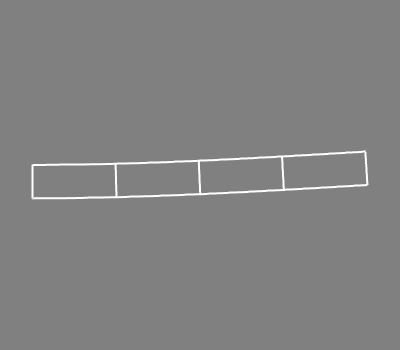

In [0]:
from IPython.display import Image, display_png

display_png(Image("u11.png"))


### ケース12の変形図

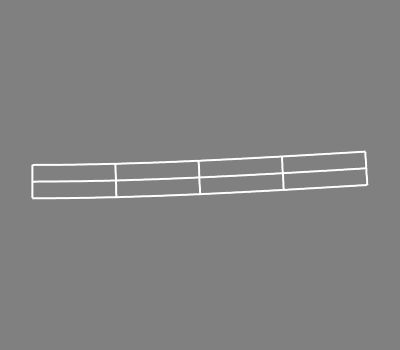

In [0]:
from IPython.display import Image, display_png

display_png(Image("u12.png"))


### ケース13の変形図

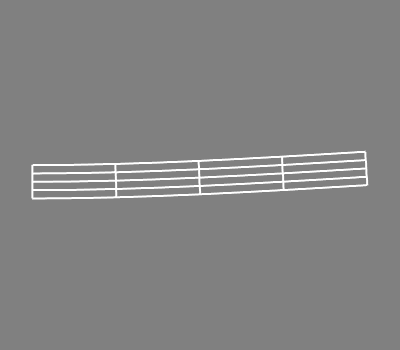

In [0]:
from IPython.display import Image, display_png

display_png(Image("u13.png"))


### ケース14の変形図

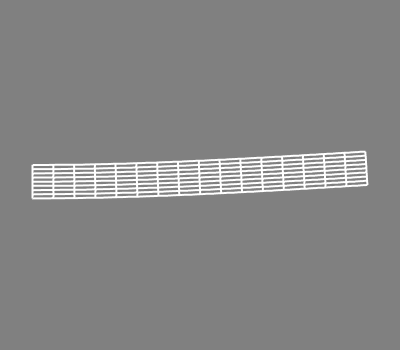

In [0]:
from IPython.display import Image, display_png

display_png(Image("u14.png"))


### ケース21の変形図

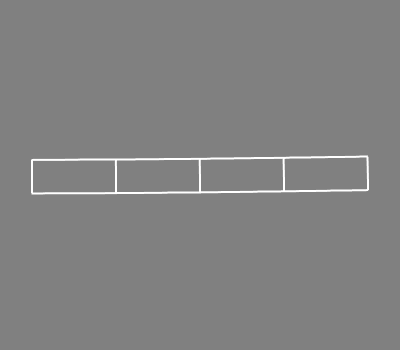

In [0]:
from IPython.display import Image, display_png

display_png(Image("u21.png"))


### ケース22の変形図

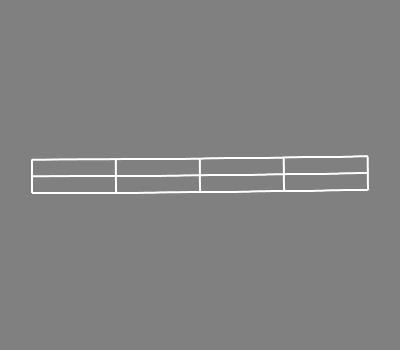

In [0]:
from IPython.display import Image, display_png

display_png(Image("u22.png"))


### ケース23の変形図

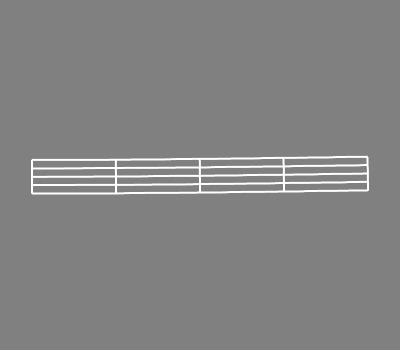

In [0]:
from IPython.display import Image, display_png

display_png(Image("u23.png"))


### ケース24の変形図

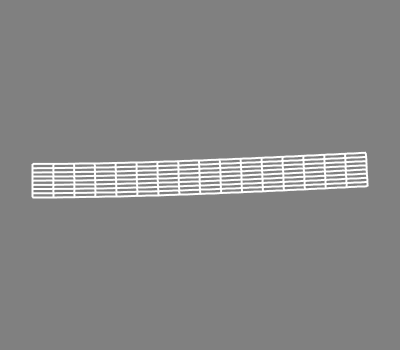

In [0]:
from IPython.display import Image, display_png

display_png(Image("u24.png"))


### ケース31の変形図

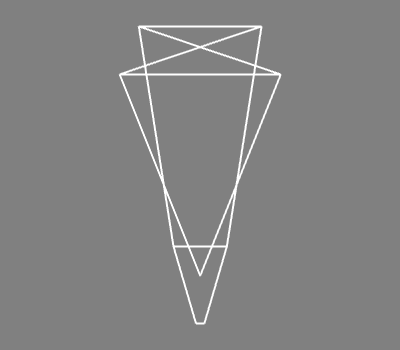

In [0]:
from IPython.display import Image, display_png

display_png(Image("u31.png"))


### ケース32の変形図

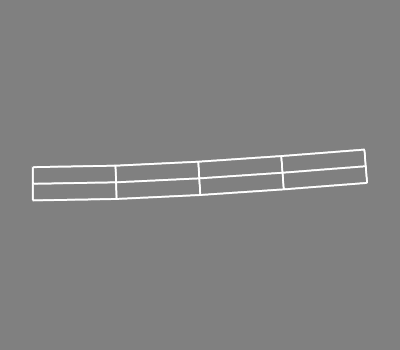

In [0]:
from IPython.display import Image, display_png

display_png(Image("u32.png"))


### ケース33の変形図

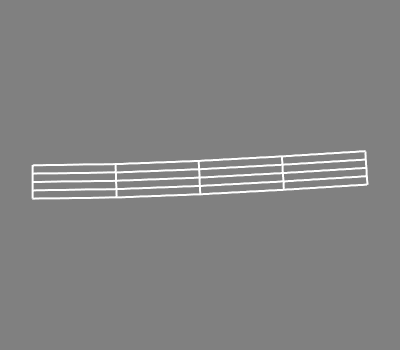

In [0]:
from IPython.display import Image, display_png

display_png(Image("u33.png"))


### ケース34の変形図

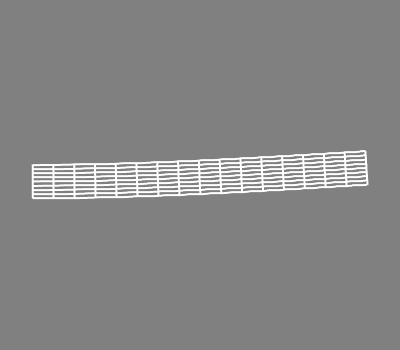

In [0]:
from IPython.display import Image, display_png

display_png(Image("u34.png"))


### ケース41の変形図

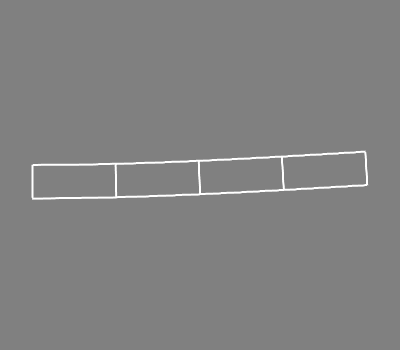

In [0]:
from IPython.display import Image, display_png

display_png(Image("u41.png"))


### ケース42の変形図

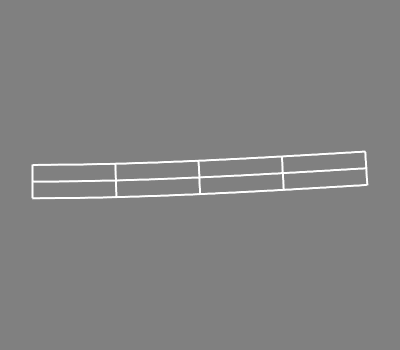

In [0]:
from IPython.display import Image, display_png

display_png(Image("u42.png"))


### ケース43の変形図

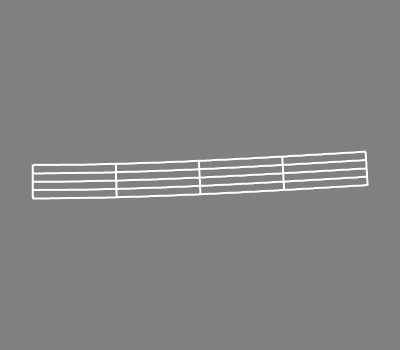

In [0]:
from IPython.display import Image, display_png

display_png(Image("u43.png"))


### ケース44の変形図

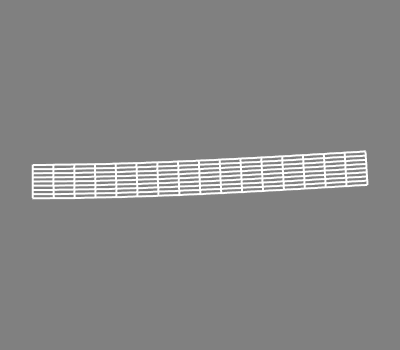

In [0]:
from IPython.display import Image, display_png

display_png(Image("u44.png"))


### 理論解との比較

In [0]:
b = 1.0
I = b*h**3.0/12.0
dmax = 1.0/3.0*(F*L**3)/(E*I)
dmax

0.4

各ケースの変形と理論解の比を計算します。まずは、右側面の最大値を確認します。

In [0]:
for md, mfu, case in zip(mds, mfus, cases):
    u = md.variable("u")
    dof = mfu.basic_dof_on_region(RIGHT_BOUND)
    print(
        case
        + " {0}".format(round(max(u[dof]), 3))
        + "/ {0} = ".format(dmax)
        + " {0}".format(round(max(u[dof] / dmax), 3))
    )


case11 0.4/ 0.4 =  0.999
case12 0.4/ 0.4 =  1.0
case13 0.4/ 0.4 =  1.0
case14 0.402/ 0.4 =  1.006
case21 0.097/ 0.4 =  0.244
case22 0.097/ 0.4 =  0.244
case23 0.097/ 0.4 =  0.244
case24 0.337/ 0.4 =  0.841
case31 26094217820.3/ 0.4 =  65235544550.7
case32 0.527/ 0.4 =  1.317
case33 0.422/ 0.4 =  1.056
case34 0.408/ 0.4 =  1.021
case41 0.4/ 0.4 =  0.999
case42 0.4/ 0.4 =  1.0
case43 0.4/ 0.4 =  1.0
case44 0.402/ 0.4 =  1.006


確認のため各ケースの左側面の変位の水平・上下の最大値を出力します。

In [0]:
for md, mfu, case in zip(mds, mfus, cases):
  u = md.variable('u')
  dof = mfu.basic_dof_on_region(LEFT_BOUND)
  print(case + " {0}".format(round(max(u[dof]), 3)))

case11 0.0
case12 0.0
case13 0.0
case14 0.0
case21 0.0
case22 0.0
case23 0.0
case24 0.0
case31 0.0
case32 0.0
case33 0.0
case34 0.0
case41 0.0
case42 0.0
case43 0.0
case44 0.0


左側面は固定端のため変位は全て0.0になっています。